# Importing Essential Libraries

In [25]:
import numpy as np
import pandas as pd
import os
import sys
from glob import glob
import tensorflow.keras
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from PIL import Image
np.random.seed(123)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import zipfile

# Data processing

In [30]:
# Step 1: Extract ZIP File (if needed)
zip_path = "C:/Users/91932/Downloads/archive (6).zip"  # Update path
extract_path = "C:/Users/91932/Downloads/archive"

In [31]:
if not os.path.exists(extract_path):  # Extract only if not already extracted
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
    print("Extraction complete!")


Extraction complete!


In [32]:
# Step 2: Set Base Directory for Images
base_skin_dir = os.path.join(extract_path, "FYP skin disease Dataset", "images")  # Update path if needed

In [33]:
# Step 3: Get All Image Paths and Store in a Dictionary
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}  # Change to *.png if needed

In [34]:
print(f"Total images found: {len(imageid_path_dict)}")

# Step 4: Define Lesion Type Labels
lesion_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

Total images found: 21501


In [35]:
# Step 5: Convert Image Paths to a Pandas DataFrame
dataset = pd.DataFrame({'path': list(imageid_path_dict.values())})

In [36]:
# Step 6: Function to Load and Process Images
def load_image(path):
    try:
        img = Image.open(path).resize((64, 64))  # Resize to 64x64
        return np.asarray(img)  # Convert to NumPy array
    except Exception as e:
        print(f"Error loading image {path}: {e}")
        return None


In [37]:
# Step 7: Apply Image Loading Function
dataset['image'] = dataset['path'].map(load_image)

# Step 8: Remove Rows with Failed Image Loads
dataset.dropna(subset=['image'], inplace=True)
print(f"Successfully loaded {len(dataset)} images.")

Successfully loaded 21501 images.


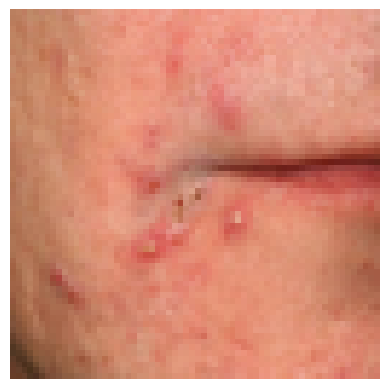

In [38]:
# Step 9: Display a Sample Image
sample_image = dataset['image'].iloc[0]  # Pick first image
plt.imshow(sample_image)
plt.axis("off")
plt.show()

# Reading Dataset and adding new columns:

In [39]:
print("Reading Dataset and adding new columns:")

dataset = pd.read_csv('HAM10000_metadata1.csv')

dataset['path'] = dataset['image_id'].map(imageid_path_dict.get)
dataset['cell_type'] = dataset['dx'].map(lesion_dict.get)
dataset['cell_codes'] = pd.Categorical(dataset['cell_type']).codes


Reading Dataset and adding new columns:


In [40]:
dataset.head()


,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_codes
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,None,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,None,Benign keratosis-like lesions,2


# Data Cleaning

In [41]:
dataset.isnull().sum()

lesion_id          0
image_id           0
dx                 0
dx_type            0
age               57
sex                0
localization       0
path            1233
cell_type          0
cell_codes         0
dtype: int64

In [42]:
dataset['age'].fillna((dataset['age'].mean()), inplace=True)

In [43]:
dataset.isnull().sum()

lesion_id          0
image_id           0
dx                 0
dx_type            0
age                0
sex                0
localization       0
path            1233
cell_type          0
cell_codes         0
dtype: int64

# Visualisations

In [44]:
def DIE():
    
    from IPython.display import HTML
    from IPython.display import display

    tag = HTML('''<script>
    code_show=true; 
    function code_toggle() 
    {
        if (code_show)
        {
            $('div.cell.code_cell.rendered.selected div.input').hide();
        } else 
        {
            $('div.cell.code_cell.rendered.selected div.input').show();
        }
        code_show = !code_show
    } 
    $( document ).ready(code_toggle);
    </script>
    <a href="javascript:code_toggle()">CODE</a>.''')
    display(tag)
DIE()

In [45]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Cell type count bar diagram

<Axes: xlabel='cell_type'>

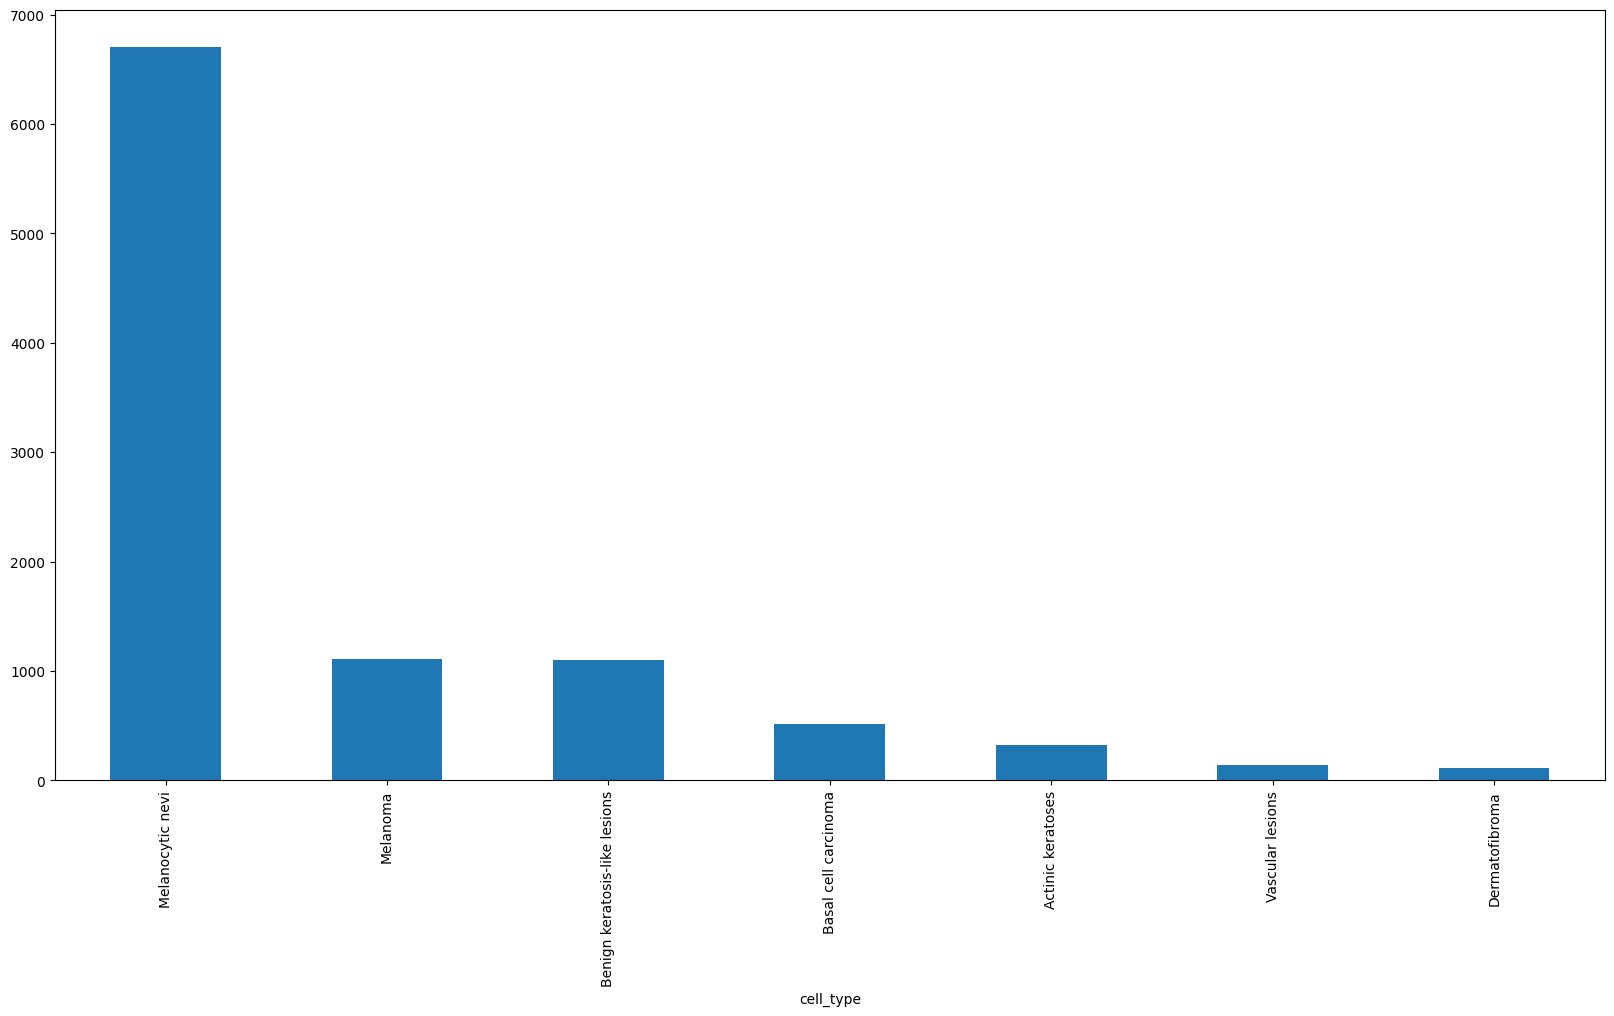

In [46]:
DIE()
fig, ax1 = plt.subplots(1, 1, figsize = (20, 10))
dataset['cell_type'].value_counts().plot(kind='bar', ax = ax1)

# Method count bar diagram

<Axes: xlabel='dx_type'>

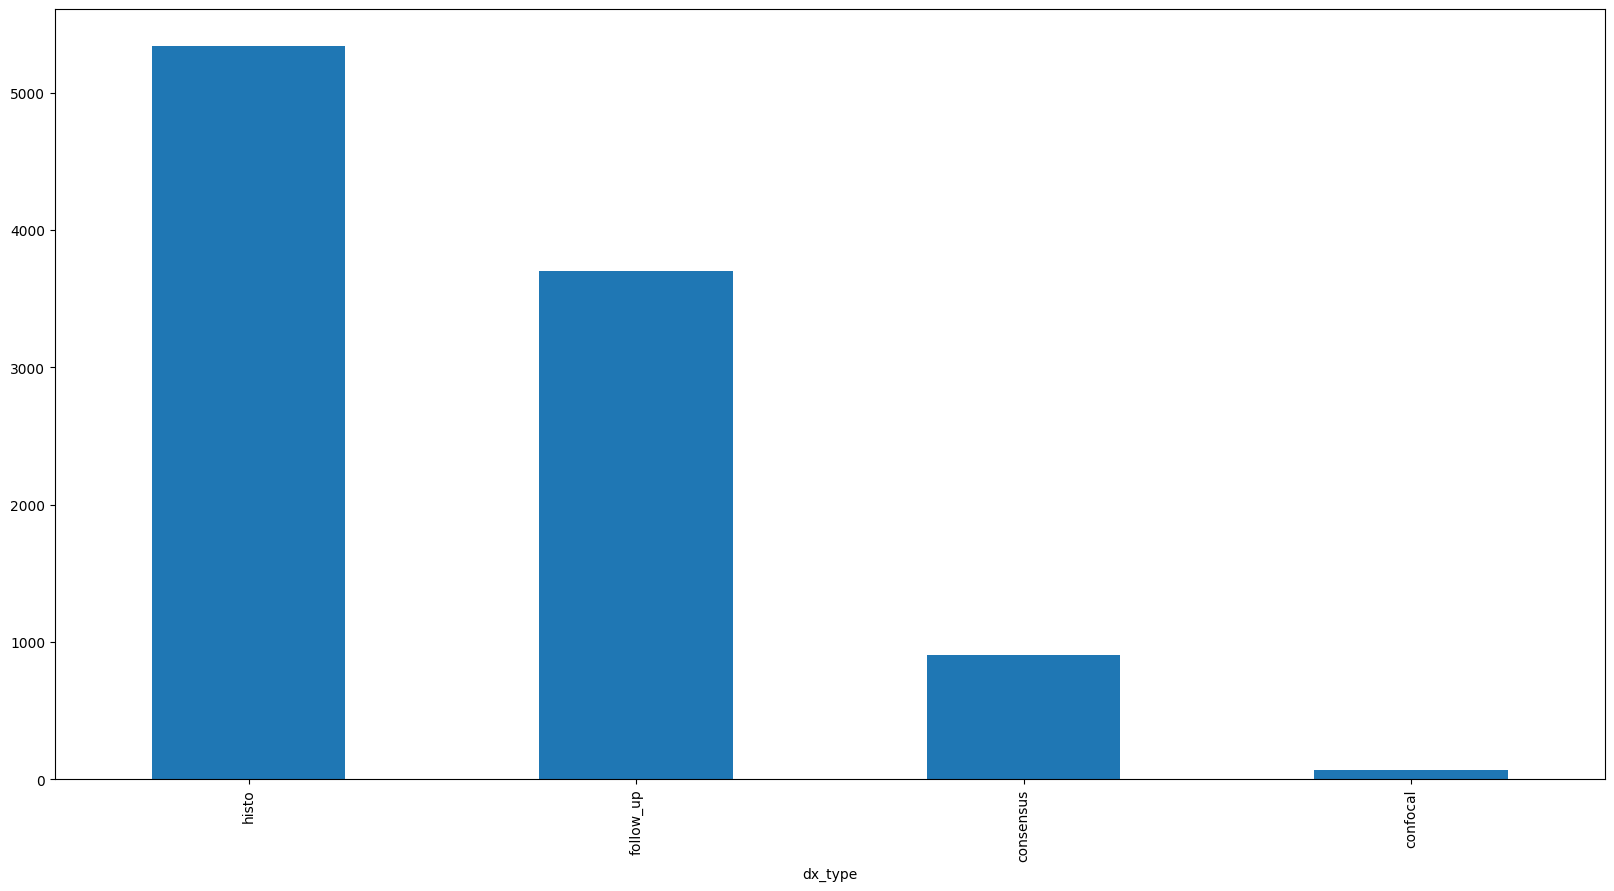

In [47]:
DIE()
fig, ax1 = plt.subplots(1, 1, figsize= (20, 10))
dataset['dx_type'].value_counts().plot(kind='bar')

# Region count bar diagram

<Axes: xlabel='localization'>

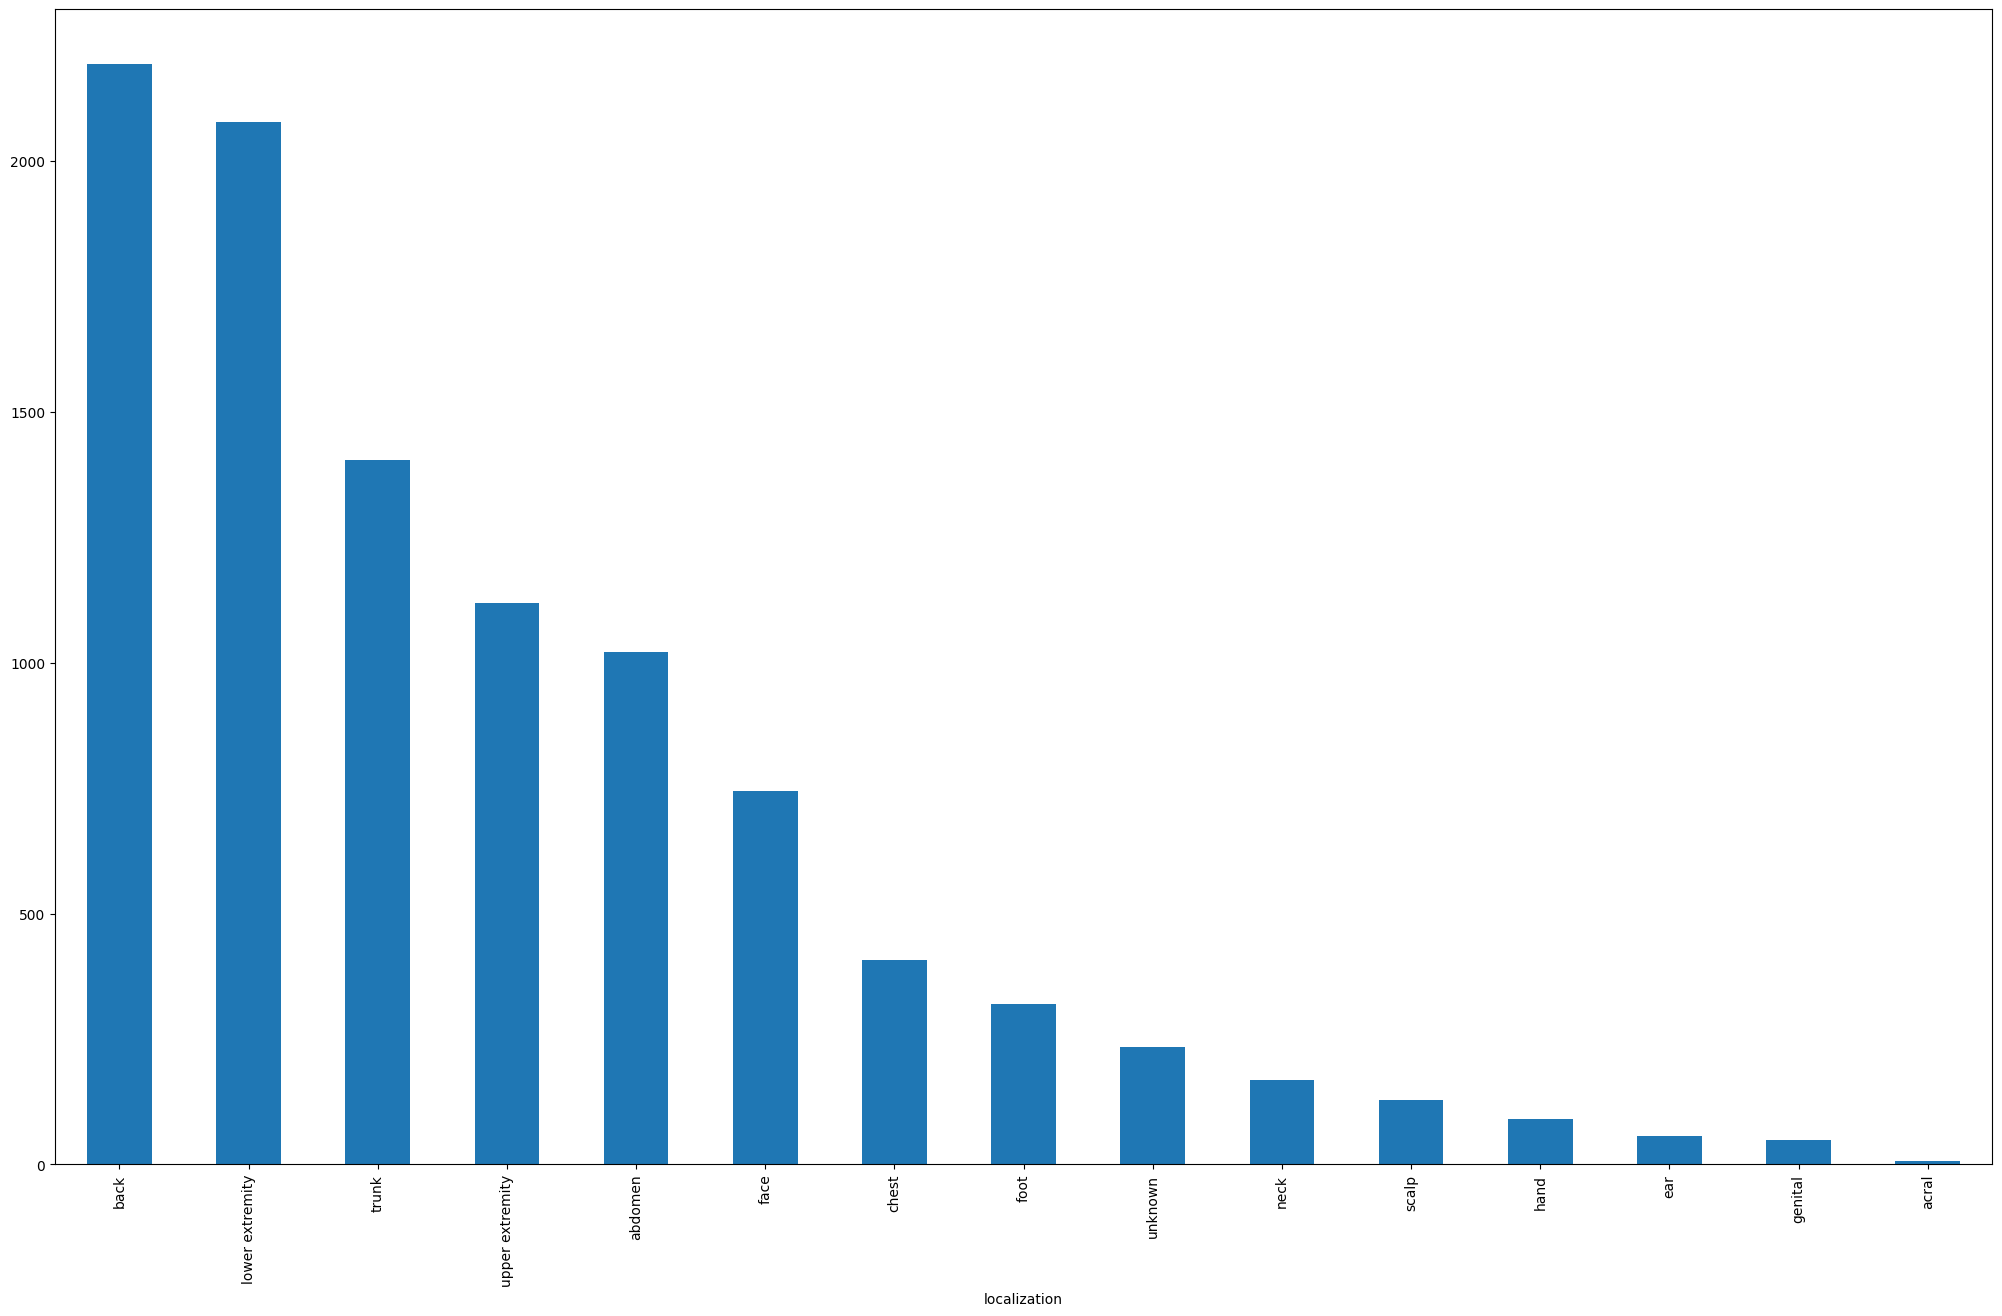

In [48]:
DIE()
fig, ax1 = plt.subplots(1, 1, figsize= (25, 15))
dataset['localization'].value_counts().plot(kind='bar')

# Age count histogram

<Axes: >

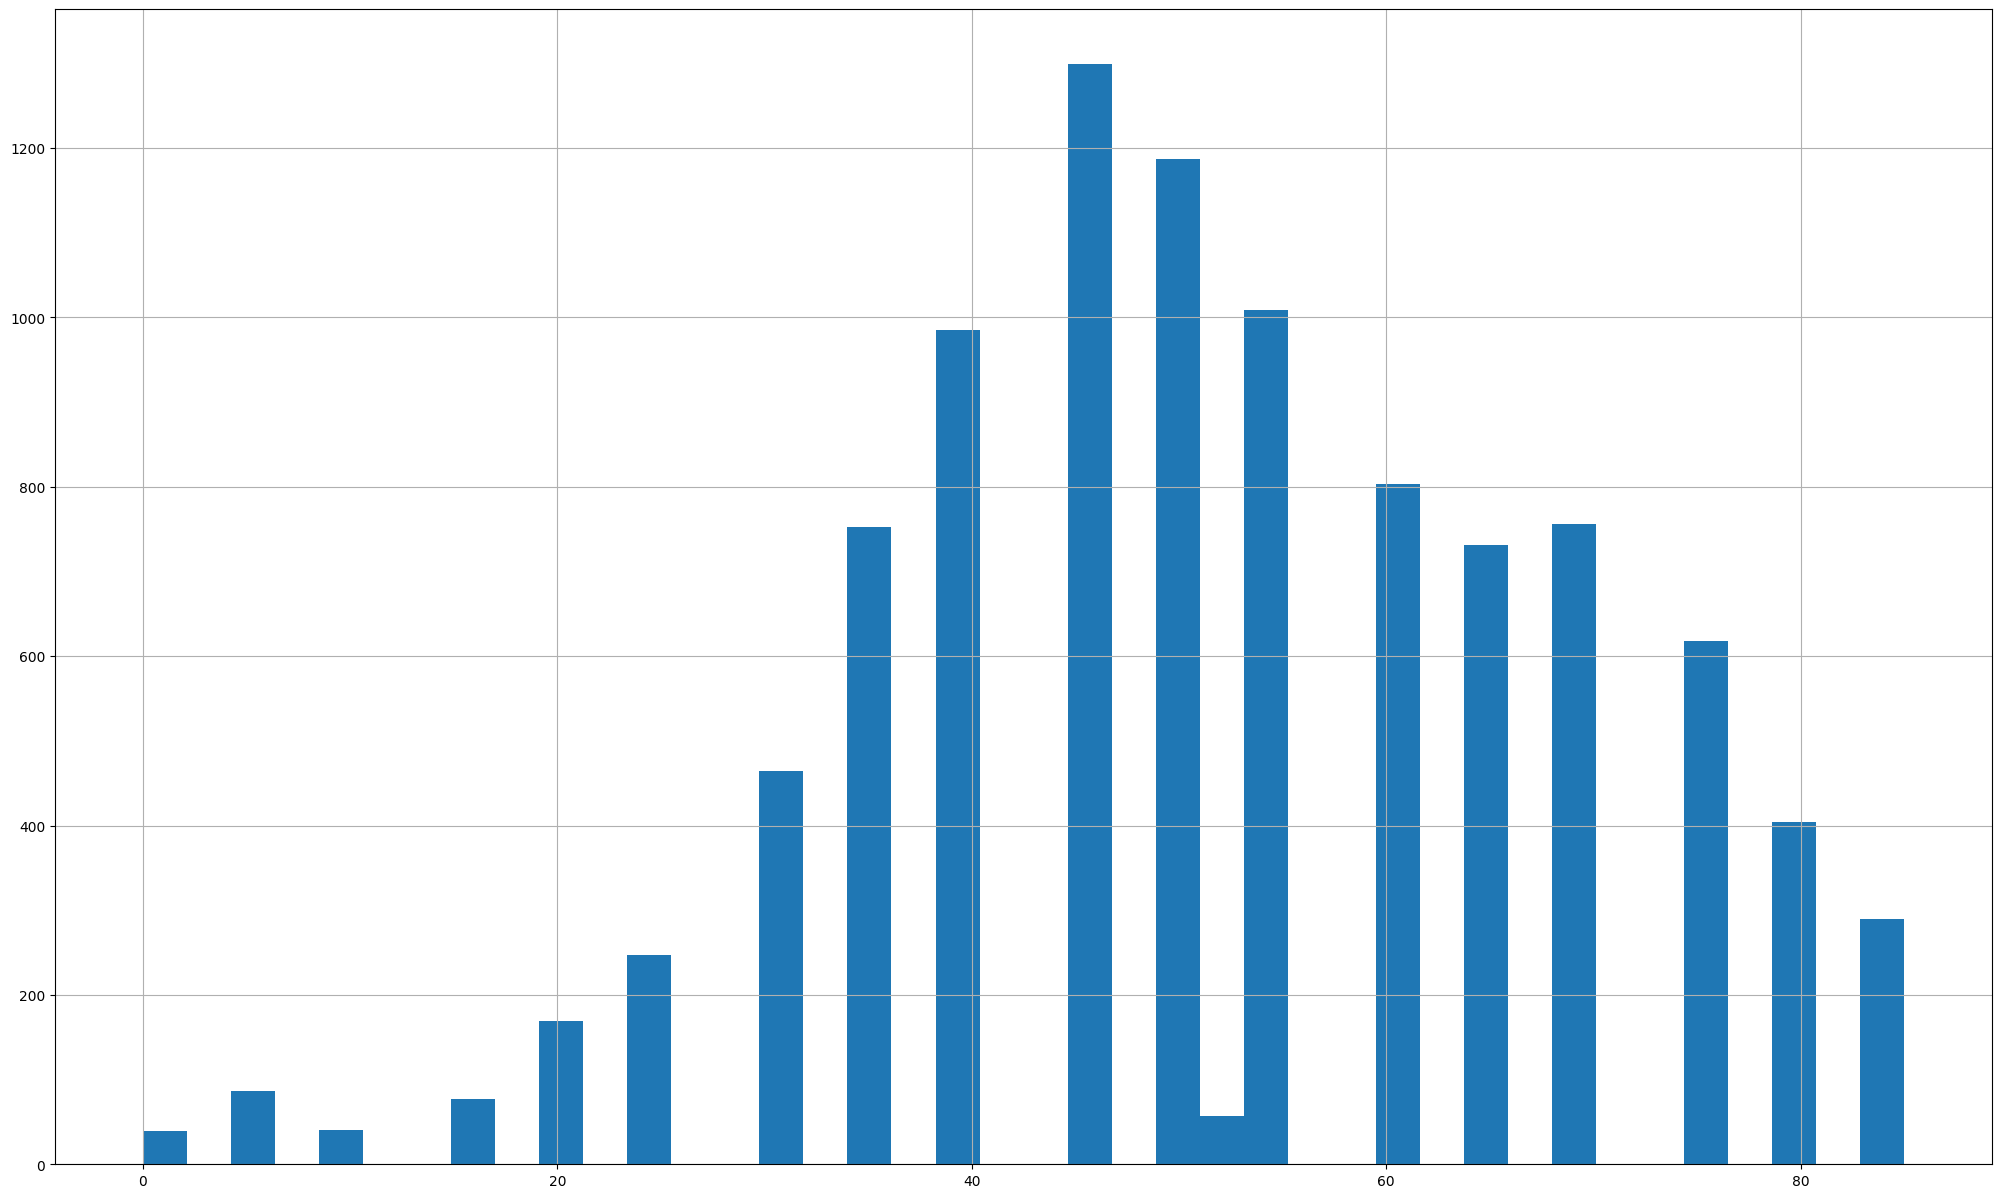

In [49]:
DIE()
fig, ax1 = plt.subplots(1, 1, figsize= (25, 15))
dataset['age'].hist(bins=40)

# Cell type count histogram


<Axes: >

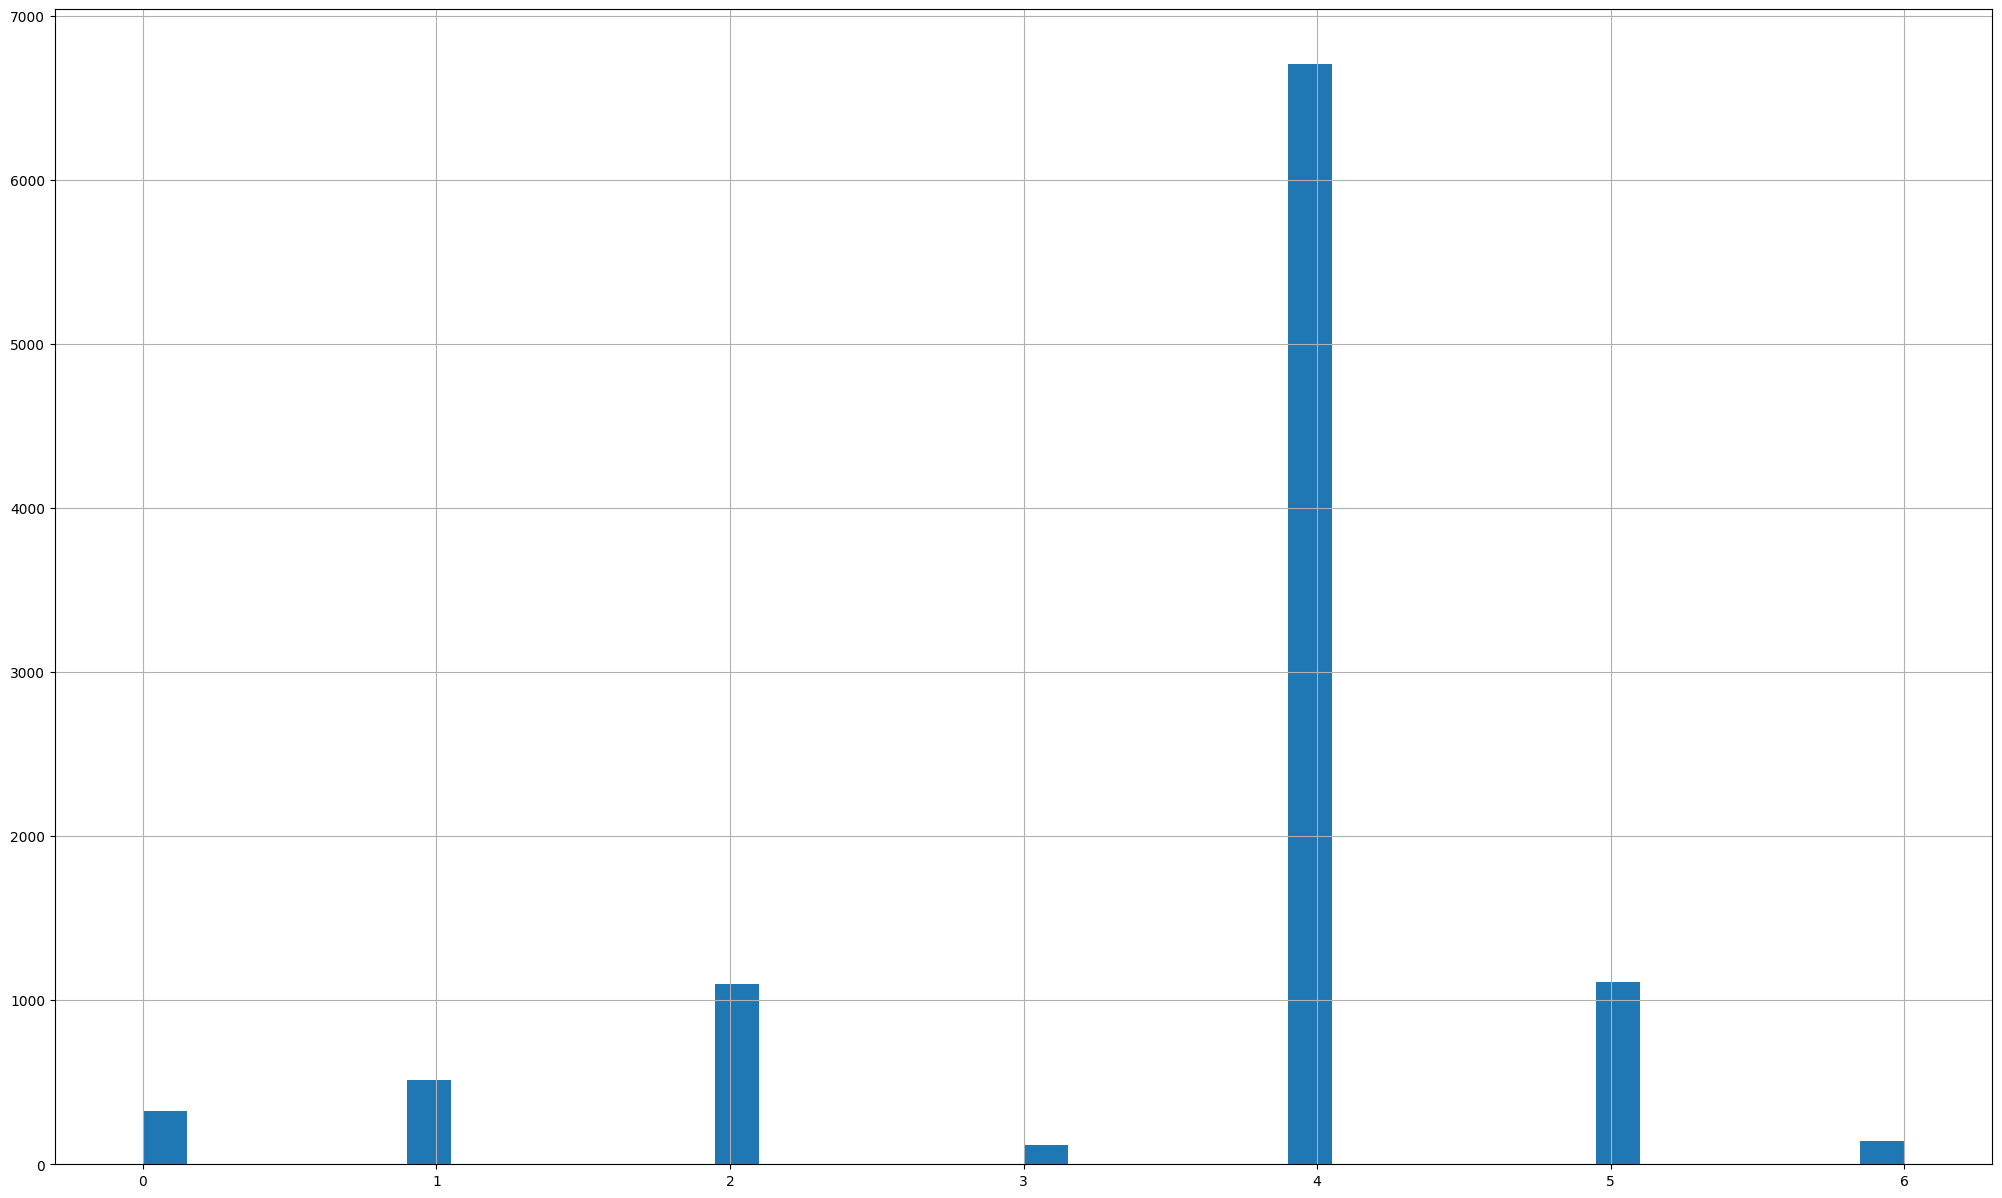

In [50]:
DIE()
fig, ax1 = plt.subplots(1, 1, figsize= (25, 15))
dataset['cell_codes'].hist(bins=40)


# Resizing the images

In [51]:
from PIL import Image
import numpy as np
import os

# Remove None values from dataset['path']
dataset = dataset.dropna(subset=['path'])  # Drop rows where 'path' is None

def load_image(path):
    if isinstance(path, str) and os.path.exists(path):  # Ensure path is a valid string
        try:
            img = Image.open(path)
            return np.asarray(img.resize((64, 64)))  # Convert image to array
        except Exception as e:
            print(f"Error loading image {path}: {e}")
            return None  # Return None for errors
    else:
        print(f"Invalid or missing path: {path}")
        return None  # Return None for invalid paths

dataset['image'] = dataset['path'].map(load_image)


In [52]:
dataset['image'] = dataset['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))


In [53]:
dataset['image'] = dataset['path'].map(lambda x: np.asarray(Image.open(x).resize((64,64))))

In [54]:
dataset.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_codes,image
64,HAM_0001751,ISIC_0024698,nv,consensus,70.0,male,face,C:/Users/91932/Downloads/archive\FYP skin dise...,Melanocytic nevi,4,"[[[163, 135, 160], [164, 136, 158], [166, 139,..."
1095,HAM_0005276,ISIC_0027008,df,histo,75.0,male,back,C:/Users/91932/Downloads/archive\FYP skin dise...,Dermatofibroma,3,"[[[157, 116, 106], [172, 134, 128], [184, 142,..."
1096,HAM_0005276,ISIC_0028790,df,histo,75.0,male,back,C:/Users/91932/Downloads/archive\FYP skin dise...,Dermatofibroma,3,"[[[211, 161, 169], [219, 168, 177], [222, 171,..."
1097,HAM_0004103,ISIC_0028880,df,histo,55.0,male,lower extremity,C:/Users/91932/Downloads/archive\FYP skin dise...,Dermatofibroma,3,"[[[219, 189, 219], [220, 190, 217], [222, 192,..."
1098,HAM_0004103,ISIC_0031309,df,histo,55.0,male,lower extremity,C:/Users/91932/Downloads/archive\FYP skin dise...,Dermatofibroma,3,"[[[31, 22, 30], [60, 42, 53], [97, 72, 85], [1..."


# Displaying Samples


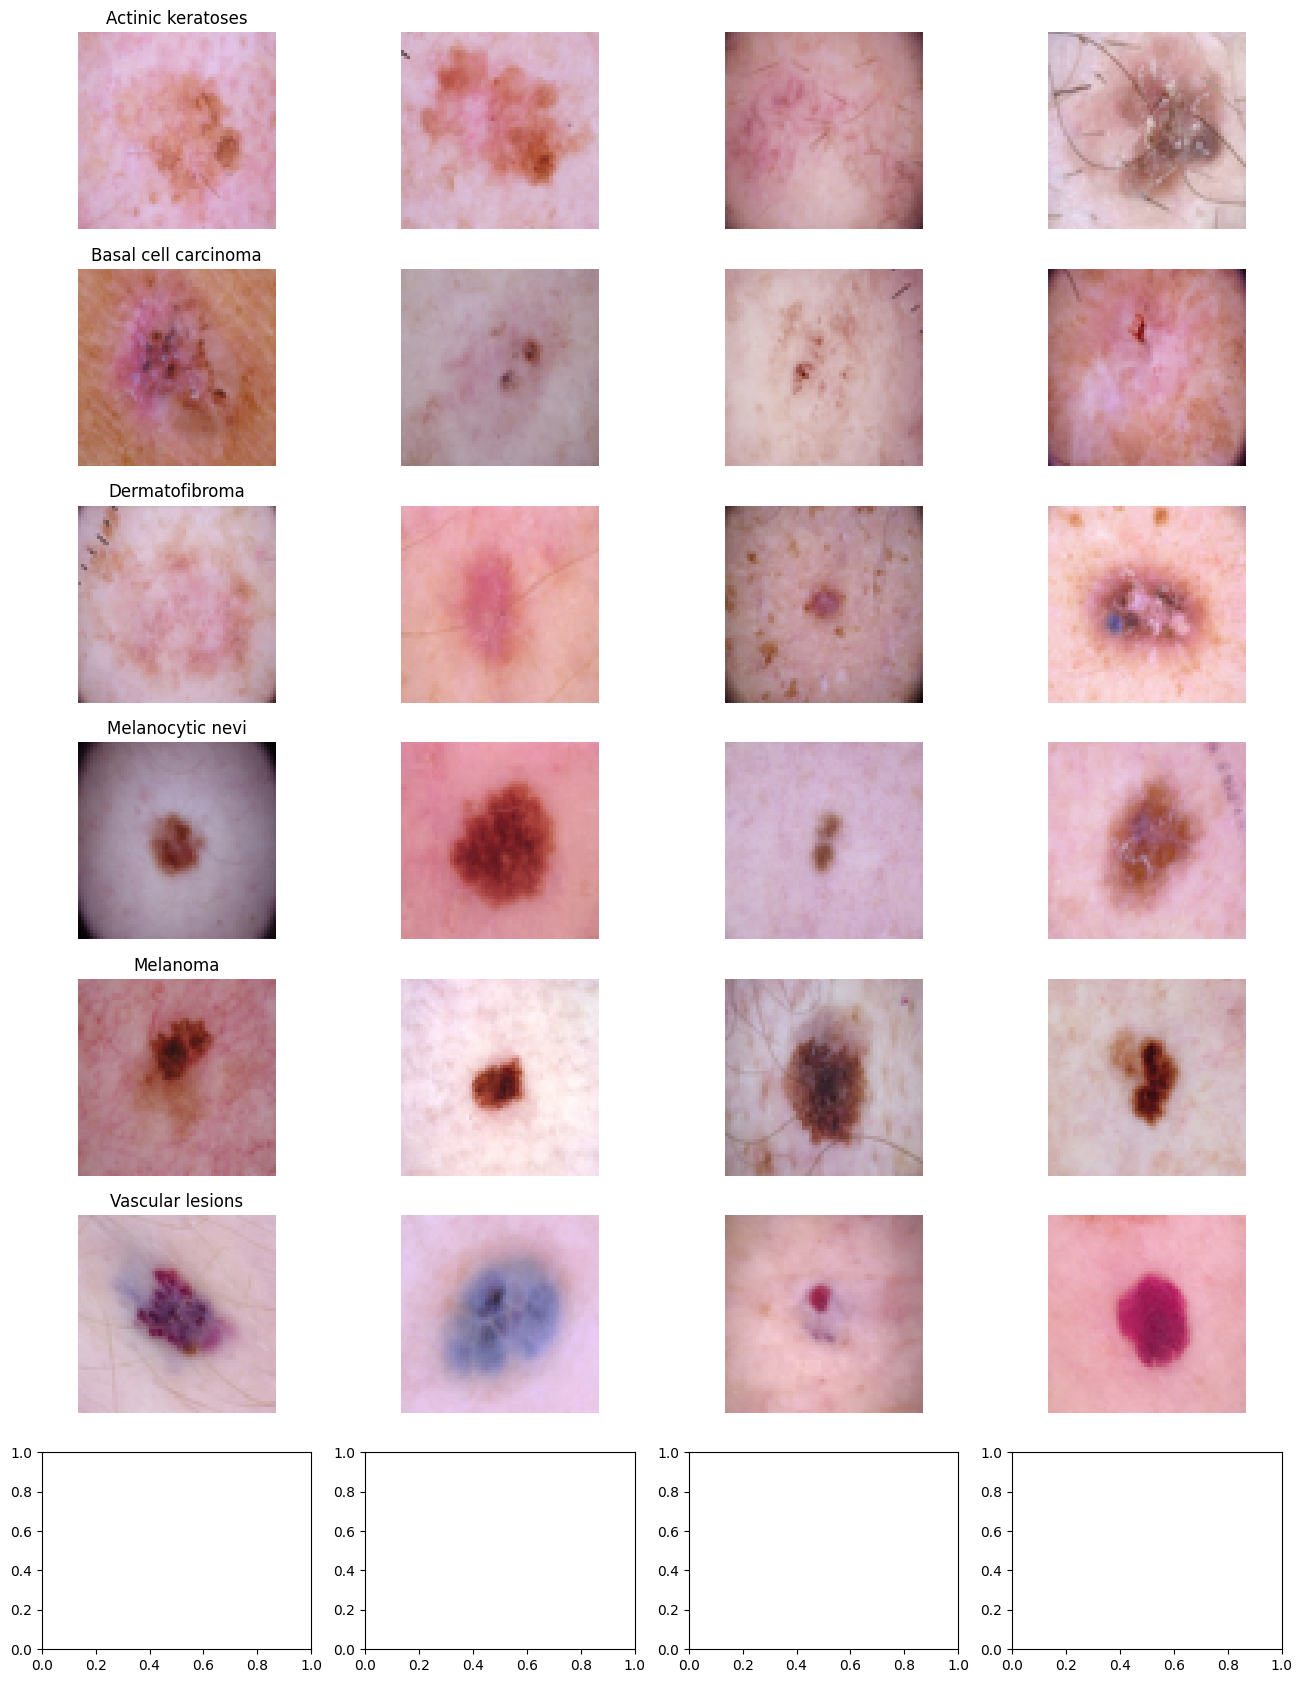

In [55]:
DIE()
import matplotlib.pyplot as plt
fig, m_axs = plt.subplots(7, 4, figsize = (4*4, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs,dataset.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(7, random_state=1).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)

# Selecting the features and targets

In [56]:
features=dataset.drop(columns=['cell_codes'],axis=1)
target=dataset['cell_codes']


# Train test splitting

In [57]:
x_train1, x_test1, y_train1, y_test1 = train_test_split(features, target, test_size=0.20,random_state=2)

# Normalising the training set

##### Normalisation reduces data redundancy.It is a process to eliminate the flaws of a database with bad design. A poorly designed database is inconsistent and create issues while adding, deleting or updating information.

In [58]:
x_train = np.asarray(x_train1['image'].tolist())
x_test = np.asarray(x_test1['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

# Performing one-hot encoding on the labels

In [59]:
y_train = to_categorical(y_train1, num_classes = 7)
y_test = to_categorical(y_test1, num_classes = 7)


# Validation and training set splitting

In [60]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)


# Reshaping image in 4 dimensions

In [61]:
x_train = x_train.reshape(x_train.shape[0], *(64, 64, 3))
x_test = x_test.reshape(x_test.shape[0], *(64, 64, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(64, 64, 3))

# CNN
USING KERAS TENSORFLOW IN BACKEND

In this model, we first appply different feature detectors or kernels onto the input image to get the first two convoled layers then we apply Max Pooling to get the max pooled layer and similiarly we obtain the next layers and finally we obtain the Flatten layer using Flatten(). Then the fully connected layers(hidden layers) to finally give the output layer of 7 neurons.

title


In [62]:
shape = (64, 64, 3)

classifier = Sequential()
classifier.add(Conv2D(32, (3, 3), activation='relu',input_shape=shape))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size = (2, 2)))
classifier.add(Dropout(0.05))

classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPool2D(pool_size=(2, 2)))
classifier.add(Dropout(0.10))

classifier.add(Flatten())

classifier.add(Dense(128, activation='relu'))
classifier.add(Dropout(0.15))
classifier.add(Dense(64, activation='relu'))

classifier.add(Dense(32, activation='relu'))
classifier.add(Dropout(0.20))

classifier.add(Dense(7, activation='softmax'))
classifier.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 30, 30, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 30, 30, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 26, 26, 64)        36928     
                                                      

# Compiling the model

In [63]:
classifier.compile(optimizer = 'adam' , loss = "categorical_crossentropy", metrics=["accuracy"])

# Categorical Cross Entropy

Categorical cross entropy is a Softmax activation plus a Cross-Entropy loss. While using this loss, we train a CNN to output a probability over the C classes for each image. It is used for multi-class classification.

title


In [64]:
datagen = ImageDataGenerator(
                            featurewise_std_normalization=False, 
                            samplewise_std_normalization=False, 
                            rotation_range=10, 
                            zoom_range = 0.1,  
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=False,  
                            vertical_flip=False
                            )
datagen.fit(x_train)

# Fitting the model

In [65]:
epochs = 50
batch_size = 10
history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              steps_per_epoch=x_train.shape[0] // batch_size)

C:\Users\91932\AppData\Local\Temp\ipykernel_2384\417452476.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = classifier.fit_generator(datagen.flow(x_train,y_train, batch_size=batch_size),


Epoch 1/50


632/632 [==============================] - 46s 69ms/step - loss: 0.8392 - accuracy: 0.7586 - val_loss: 0.6570 - val_accuracy: 0.7767
Epoch 2/50
632/632 [==============================] - 44s 69ms/step - loss: 0.6990 - accuracy: 0.7703 - val_loss: 0.6202 - val_accuracy: 0.7895
Epoch 3/50
632/632 [==============================] - 43s 68ms/step - loss: 0.6412 - accuracy: 0.7727 - val_loss: 0.5888 - val_accuracy: 0.7881
Epoch 4/50
632/632 [==============================] - 43s 68ms/step - loss: 0.6251 - accuracy: 0.7763 - val_loss: 0.5677 - val_accuracy: 0.7952
Epoch 5/50
632/632 [==============================] - 43s 68ms/step - loss: 0.5934 - accuracy: 0.7898 - val_loss: 0.5235 - val_accuracy: 0.8080
Epoch 6/50
632/632 [==============================] - 45s 71ms/step - loss: 0.5628 - accuracy: 0.7937 - val_loss: 0.5889 - val_accuracy: 0.7966
Epoch 7/50
632/632 [==============================] - 44s 70ms/step - loss: 0.5556 - accuracy: 0.7955 - val_loss: 0.5162 - val_accurac

# Calculating validation set and test set accuracies

In [66]:
loss, accuracy = classifier.evaluate(x_test, y_test)
loss_v, accuracy_v = classifier.evaluate(x_validate, y_validate)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
classifier.save("classify.h5")

22/22 [==============================] - 1s 37ms/step - loss: 0.4956 - accuracy: 0.8336
Validation: accuracy = 0.833570  ;  loss_v = 0.495631
Test: accuracy = 0.831531  ;  loss = 0.498466


C:\all files\anaconda\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Plotting model's validation loss and validation accuracy

In [69]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    # Summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy'])+1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy'])+1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy'])+1))  # ✅ Fixed
    axs[0].legend(['Train', 'Val'], loc='best')

    # Summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss'])+1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss'])+1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss'])+1))  # ✅ Fixed
    axs[1].legend(['Train', 'Val'], loc='best')

    plt.show()

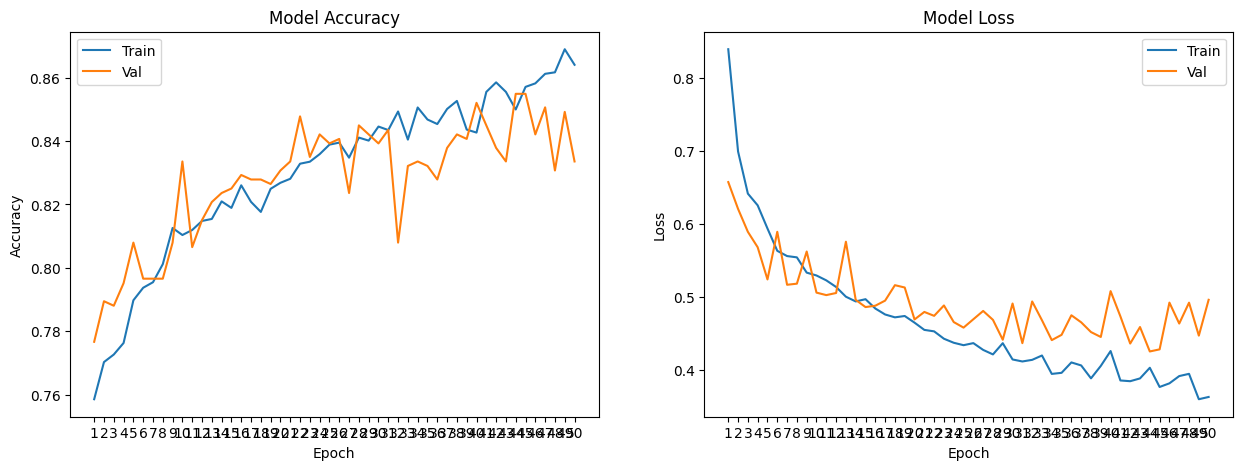

In [70]:


plot_model_history(history)




# Confusion Matrix

22/22 [==============================] - 1s 44ms/step


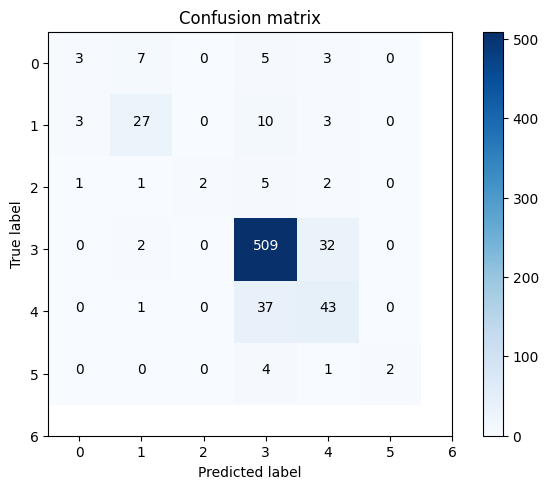

In [71]:
DIE()
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    decoy = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > decoy else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

#Predicting the values from the validation dataset
Y_pred = classifier.predict(x_validate)
#Converting predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
#Converting validation observations to one hot vectors
Y_true = np.argmax(y_validate,axis = 1) 
#Computing the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

plot_confusion_matrix(confusion_mtx, classes = range(7)) 


In [ ]:
from keras.preprocessing import image
test_image1 = image.load_img('C:/Users/Pavithra/Desktop/test2.jpg', target_size = (64, 64))
test_image1 = image.img_to_array(test_image1)
test_image1 = np.expand_dims(test_image1, axis = 0)
result = classifier.predict(test_image1)
if result[0][0] == 1:
    print('TYPE:-\n Actinic keratoses')
elif result[0][1] == 1:
    print('TYPE:-\n Basal cell carcinoma')
elif result[0][2] == 1:
    print('TYPE:-\n Benign keratosis-like lesions')
elif result[0][3] == 1:
    print('TYPE:-\n Dermatofibroma')
elif result[0][4] ==1 :
    print('TYPE:-\n Melanoma')
elif result[0][5] == 1:
    print('TYPE:-\n Melanocytic nevi')
elif result[0][6] == 1:
    print('TYPE:-\n Vascular lesions')

In [73]:
from keras.preprocessing import image
test_image1 = image.load_img('ISIC_0000002.jpg', target_size = (64, 64))
test_image1 = image.img_to_array(test_image1)
test_image1 = np.expand_dims(test_image1, axis = 0)
result = classifier.predict(test_image1)
if result[0][0] == 1:
    print('TYPE:-\n Actinic keratoses')
elif result[0][1] == 1:
    print('TYPE:-\n Basal cell carcinoma')
elif result[0][2] == 1:
    print('TYPE:-\n Benign keratosis-like lesions')
elif result[0][3] == 1:
    print('TYPE:-\n Dermatofibroma')
elif result[0][4] ==1 :
    print('TYPE:-\n Melanoma')
elif result[0][5] == 1:
    print('TYPE:-\n Melanocytic nevi')
elif result[0][6] == 1:
    print('TYPE:-\n Vascular lesions')

1/1 [==============================] - 0s 121ms/step
TYPE:-
 Melanoma
